<a href="https://colab.research.google.com/github/XueYang0130/1CSD1_Thesis/blob/main/3_Qflip_Role_Swapped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Part 1**
###In thie experiment, the roles of p0 and p1 are swapped. Therefore, p0 is the attacker that plays with a periodic strategy with random noise, and p1 is the defender that plays with an adaptive strategy. This experiment is under the same assumptions as in the experiment "QFlip_Random Noise".

In [27]:
#import libraries
import numpy as np
import random 
import matplotlib.pyplot as plt

In [40]:
#define an environment class
#p0: attacker, p1: defender

class Env(object):
  def __init__(self):
    #initialization
    self.actions=[0,1]  #two actions: 0 doesn't move; 1 move 
    self.tick=0   #time tick
    self.cost=[5,1] #costs of p0 and p1 respectively
    self.period=50 #initialize the period as 50 indicating that the defender moves exactly at 50 time units after the previous move
    self.acc_period=50 #sum of all periods which have happened to p0
    self.period_list=[] #store all periods in this list
    self.c=5 #a constant for use in reward function below
    self.reward_constant_norm=(self.period-self.cost[1])/self.c # this reword function is defined in [1]
    self.init_state= -1 #initial state observed by the defender/agent
    self.state = self.init_state # 'state' is the time since the opponent's last "know" move at time t (maybe not true last move time)
    self.p0_moves = [0] #a list of move ticks for p0
    self.p1_moves = [0] #a list of move ticks for p1
    self.duration=100000 #the maximum time detps
    self.done=False #indicates whether the game is over
    self.controller=1 #indicates who control the resource
    self.total_gain=[0,0] #the 1st element:accumulated gain for p0; the 2nd element: the accumalated gain for p1.
    self.total_cost=[5,1] #the 1st element:the accumulated cost for p0; the 2nd element: the accumulated cost for p1.
    self.p0_avr_benefit=[] #a list of the average benefits of p0 at each time tick
    self.p1_avr_benefit=[]  #a list of the average benefits of p1 at each time tick
    self.p1_control_count = 0 #how many times of flipping that happen to p1
    self.period_count=0
    self.avr_hold_time=0
    self.avr_hold_time_list = [] #a list of durations of p1 controling the resource in each period

  def step(self,action,tick, scale,prob):
    reward = 0 
    if tick==self.acc_period: #the tick that p0 should move
        self.generate_period(scale,prob) #generate a new period with a given margin and probability
        self.acc_period+=self.period #update the new accumulated periods
        self.period_count+=1
        self.period_list.append(self.period)
        
        #if p0 and p1 move together, p1/defender will control the resource
        if action == 1:
          #flipping - p1 takes control of the resource from p0
          self.state = tick - self.p0_moves[-1] +1 #next state
          reward = self.reward_constant_norm
          self.controller=1
          self.total_cost[1]+=self.cost[1] #add cost to p1
          self.total_cost[0]+=self.cost[0] #add cost to p0
          self.p1_moves.append(tick) #update move time list for p1
          self.p0_moves.append(tick) #update move time list for p0

        else:# p0 moves, p1 doesn't move   
          #p0/attacker can only takes control of the resource in this situation (flipping for p0)
          self.state += 1 #next state 
          self.controller=0 #update the controlloer
          self.total_cost[0]+=self.cost[0] #add cost to p0
          self.p0_moves.append(tick) #update p0 move times list
    
    else: #the tick that p0 doesn't move
        if action == 1:# p1 moves, p0 doesn't move
            #flipping - p1 takes control of the resource
            if self.controller == 0:
              reward = self.reward_constant_norm
              self.state = tick - self.p0_moves[-1]+1
              self.controller = 1
            else:
              reward = -self.cost[1] #generate reward
              self.state += 1 #next state
            self.p1_moves.append(tick) #update move time list for p1
            self.total_cost[1]+=self.cost[1] #update total cost for p1
            self.controller=1 #update the controller
        else:# both hold 
            self.state += 1 #next state

    if tick==self.duration: #check if the game is over
      self.done=True
    
    self.total_gain[self.controller]+=1 #update the total_gain list
    self.p0_avr_benefit.append((self.total_gain[0]-self.total_cost[0])/(tick+1)) #add the new average benefit to the corresponding list for p0
    self.p1_avr_benefit.append((self.total_gain[1]-self.total_cost[1])/(tick+1)) #add the new average benefit to the corresponding list for p1

    #calcuate average holding time of p1/defender
    if self.controller==1:
      self.p1_control_count+=1
    if self.period_count!=0 and tick%50==0:
      self.avr_hold_time=self.p1_control_count/self.period_count
      self.avr_hold_time_list.append(self.avr_hold_time)

    return self.state, reward, self.done #return next state/observation, reward for the agent, and the state of 'done'
  
  def generate_period(self,scale,prob): #"margin" controlls how far away from the default period 50, "prob" indicates the probability of adding noise to the period
    if np.random.rand()<prob: 
      #add random noise to the period
      self.period=random.choice(list(range(50-scale,50+scale+1)))
    else: #set the period as default 50
      self.period=50
    
  def reset(self): #reset the environment
    self.actions=[0,1] 
    self.tick=0 
    self.cost=[5,1] 
    self.period=50 
    self.acc_period=50 
    self.period_list=[] 
    self.c=5 
    self.reward_constant_norm=(self.period-self.cost[1])/self.c 
    self.init_state= -1 
    self.state = self.init_state 
    self.p0_moves = [0] 
    self.p1_moves = [0] 
    self.duration=1000000
    self.done=False 
    self.controller=1 
    self.total_gain=[0,0] 
    self.total_cost=[5,1] 
    self.p0_avr_benefit=[] 
    self.p1_avr_benefit=[]  
    self.p1_control_count = 0 
    self.period_count=0
    self.avr_hold_time=0
    self.avr_hold_time_list = [] 


In [41]:
#define an agent class for the p1/attacker
class Agent(object):
  def __init__(self,env):
    self.env=env
    #initialisation
    self.alpha = 0.3 #learning rate
    self.gamma=0.8 #discount value
    self.actions=[0,1] #actions can be chosen
    self.Q_table=np.zeros((100000,2)) #create a Q table and initialise all values to be zero
    self.cur_state=self.env.state #get the current state from the environment
    self.next_state=0 #the next state is initialised to be 0

  def do_step(self,epsilon,tick, scale, prob):
    action=self.epsilon_greedy(self.cur_state, epsilon) #select an action
    self.next_state, reward, done=self.env.step(action,tick, scale, prob)  #take the action, and get the next state, reward and the state of "done" from the environment
    self.update_Q(reward, self.cur_state, self.next_state,action) #update Q table
    self.cur_state=self.next_state #update the new current state
    return done #return the state of "done"

  def epsilon_greedy(self, state, epsilon): #exporation-exploitation
    if np.random.rand()<epsilon:
      return random.choice(self.actions) #select an action at random
    else:
      return np.argmax(self.Q_table[state]) #select the action with the maximum Q value at that state given the Q table

  def update_Q(self, reward, cur_state, next_state, action): #update Q table given the Q-learning algorithm
    self.Q_table[cur_state, action]=self.Q_table[cur_state, action]+self.alpha*(reward+self.gamma*np.max(self.Q_table[next_state])-self.Q_table[cur_state,action])



###**Part 2**
###When there is no noise in the moving period of p0 (prob=0, scale=0).The setup has some characterestics: there are fewer states in the Q table;the duration can be set as a samller number. For example:
* duration=50000
* Q_table=np.zeros((100,2))



### Print the last 100 move ticks for p0 and p1, respectively.

In [42]:
env = Env() #create an environment object
attacker = Agent(env) #create an agent object
scales=list(range(1, 21)) #the range of scale of noise
prob=0.2 #probability of adding a random noise
final_avr_benefit_p1=[] #the final average benefit for p1 with different scale values
final_avr_benefit_p0=[] #the final average benefit for p1 with different scale values

for scale in scales: #loop for scale in {1, 2, 3, ..., 20}
  avr_benefit_p1=[]
  avr_benefit_p0=[]
  for i in range(1): #perform 10 times
    env.reset() #reset environment
    epsilon = 1 #define epsilon with an initial value of 1
    for tick in range(env.duration): 
      epsilon=max(epsilon-4/env.duration, 0.00) # update epsilon with decay
      attacker.do_step(epsilon,tick,scale,prob) #let the agent take step
    avr_benefit_p1.append(env.p1_avr_benefit[-1])
    avr_benefit_p0.append(env.p0_avr_benefit[-1])
    if i==9: 
      final_avr_benefit_p1.append(np.mean(avr_benefit_p1))
      final_avr_benefit_p0.append(np.mean(avr_benefit_p0))


In [5]:
#print the moves times of p0 and p1
print("P0:",env.p0_moves[-100:]) 
print("P1:",env.p1_moves[-100:]) 

P0: [95000, 95050, 95100, 95150, 95200, 95250, 95300, 95350, 95400, 95450, 95500, 95550, 95600, 95650, 95700, 95750, 95800, 95850, 95900, 95950, 96000, 96050, 96100, 96150, 96200, 96250, 96300, 96350, 96400, 96450, 96500, 96550, 96600, 96650, 96700, 96750, 96800, 96850, 96900, 96950, 97000, 97050, 97100, 97150, 97200, 97250, 97300, 97350, 97400, 97450, 97500, 97550, 97600, 97650, 97700, 97750, 97800, 97850, 97900, 97950, 98000, 98050, 98100, 98150, 98200, 98250, 98300, 98350, 98400, 98450, 98500, 98550, 98600, 98650, 98700, 98750, 98800, 98850, 98900, 98950, 99000, 99050, 99100, 99150, 99200, 99250, 99300, 99350, 99400, 99450, 99500, 99550, 99600, 99650, 99700, 99750, 99800, 99850, 99900, 99950]
P1: [95000, 95050, 95100, 95150, 95200, 95250, 95300, 95350, 95400, 95450, 95500, 95550, 95600, 95650, 95700, 95750, 95800, 95850, 95900, 95950, 96000, 96050, 96100, 96150, 96200, 96250, 96300, 96350, 96400, 96450, 96500, 96550, 96600, 96650, 96700, 96750, 96800, 96850, 96900, 96950, 97000, 970

###From the above, the defender move at the same time with attacker with a period of 50. This is because of the assumotion that if defener and attacker move together, defender will control the resource.

###The visualization of the average benefit for p1 has converged.

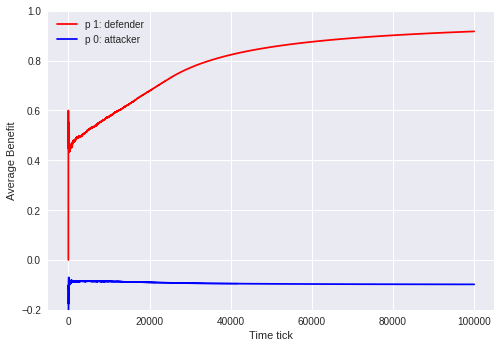

In [20]:
#visualiztaion of the change of average benefit for p0 and p1
plt.style.use('seaborn')
plt.figure()
#plt.title( "The change of average benefit for P0 and p1")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p1_avr_benefit,color = "red",label="p 1: defender")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p0_avr_benefit, color = "blue",label="p 0: attacker")
plt.ylim(-0.2, 1)
plt.xlabel("Time tick")
plt.ylabel("Average Benefit")
plt.legend()

###Given the following figure, the maximum controling time for the defender per period is close to 50 as the game progresses.

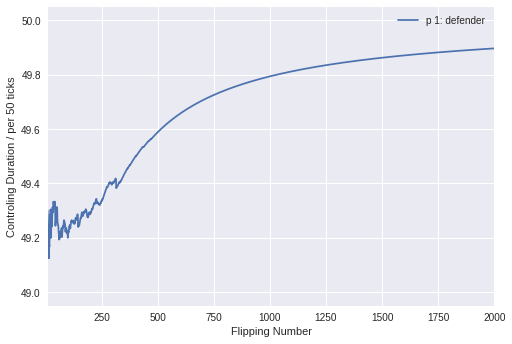

In [22]:
#visualiztaion of the duration for p1 to control the resource in each period of 50 ticks
plt.style.use('seaborn')
plt.figure()
#plt.title( "The duration for p1 to control the resource in each period of 50 ticks")
plt.plot(np.array(range(env.period_count)), env.avr_hold_time_list,label="p 1: defender")
plt.xlim(10, 2000)
plt.xlabel("Flipping Number")
plt.ylabel("Controling Duration / per 50 ticks")
plt.legend()

###**Part 3**

###When there are some random noises to the moving period of p0 (prob!=0, scale!=0), the setting should be changed as follows: there are more states in the Q table, the duration can be longer, epsilon can decay with a smaller step. Here is an example:

* In the generate_period(scale,prob) method, prob=0.2, scale=5
* duration=100000
* Q_table=np.zeros((100000,2))
* epsilon=max(1-4/100000, 0.00)

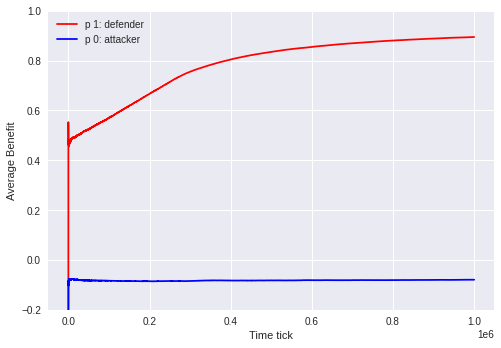

In [43]:
#visualiztaion
plt.style.use('seaborn')
plt.figure()
#plt.title( "The change of average benefit for P0 and p1")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p1_avr_benefit,color = "red",label="p 1: defender")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p0_avr_benefit, color = "blue",label="p 0: attacker")
plt.ylim(-0.2, 1)
plt.xlabel("Time tick")
plt.ylabel("Average Benefit")
plt.legend()

###From the above visualization, the average benefir for the agent p1 converges and the defender can maximize its average benefit.

### **Part 4 Observe the change of average benefit based on the change of "probability" or "scale"**

In [33]:
print(final_avr_benefit_p0)
print(final_avr_benefit_p1)

[-0.07304200000000001, -0.074254, -0.07807800000000001, -0.082135, -0.07926, -0.07252800000000001, -0.071305, -0.073049, -0.073109, 0.009161999999999997, -0.071999, -0.06929, -0.064552, -0.060017, -0.06948399999999999, -0.06862399999999999, -0.06606299999999998, -0.06529, -0.06436, -0.063573]
[0.890619, 0.8908929999999999, 0.894397, 0.896443, 0.893514, 0.886484, 0.885233, 0.8874550000000001, 0.887022, 0.8049430000000001, 0.8835770000000001, 0.8817830000000001, 0.876834, 0.872016, 0.879958, 0.879861, 0.876679, 0.877473, 0.875921, 0.8743749999999999]


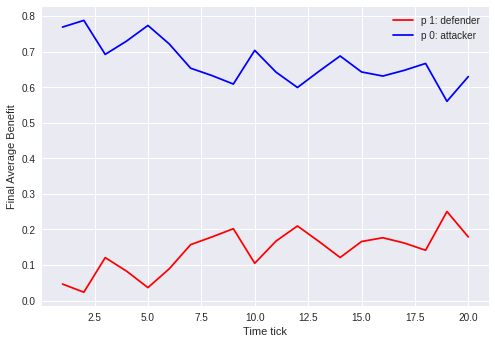

In [38]:
#Viusalize the above results given prob=(0.2, 0.4, 0.6) and scale= {1, 2, 3, ...,20}
plt.style.use('seaborn')
plt.figure()
plt.plot(np.array(range(1, 21)), final_avr_benefit_p0, color = "red",label="p 1: defender")
plt.plot(np.array(range(1, 21)), final_avr_benefit_p1, color = "blue",label="p 0: attacker")
#plt.ylim(-0.2, 1)
plt.xlabel("Time tick")
plt.ylabel("Final Average Benefit")
plt.legend()